In [1]:
import sys

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    Parameters
    ----------
    iteration :
                Current iteration (Int)
    total     :
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [2]:
import numpy as np
import cv2
from skimage.feature import hog

class FeatureExtractor(object):
    """
    Helps extracting features from an image in regions.
    """

    def __init__(self, image, orient=10, pix_per_cell=8, cell_per_block=2):
        """
        Initialises an instance.
        Parameters
        ----------
        image           : Image to extract features from.
        orient          : HoG orientations.
        pix_per_cell    : HoG pixels per cell.
        cell_per_block  : HoG cells per block.
        """
        self.image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        (self.h, self.w, self.d) = self.image.shape
        self.hog_features = []
        self.pix_per_cell = pix_per_cell
        for channel in range(self.d):
            self.hog_features.append(
                hog(self.image[:, :, channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                    visualise=False, feature_vector=False)
            )
        self.hog_features = np.asarray(self.hog_features)

    def hog(self, x, y, k):
        """
        Gets HoG features for specified region of the image.
        Parameters
        ----------
        x   : Image X coordinate.
        y   : Image Y coordinate.
        k   : Region size (single value, side of a square region).
        Returns
        -------
        HoG vector for the specified region.
        """
        hog_k = (k // self.pix_per_cell) - 1
        hog_x = max((x // self.pix_per_cell) - 1, 0)
        hog_x = self.hog_features.shape[2] - hog_k if hog_x + hog_k > self.hog_features.shape[2] else hog_x
        hog_y = max((y // self.pix_per_cell) - 1, 0)
        hog_y = self.hog_features.shape[1] - hog_k if hog_y + hog_k > self.hog_features.shape[1] else hog_y
        return np.ravel(self.hog_features[:, hog_y:hog_y+hog_k, hog_x:hog_x+hog_k, :, :, :])

    def bin_spatial(self, image, size=(16, 16)):
        """
        Computes spatial vector.
        Parameters
        ----------
        image   : Image to get spatial vector for.
        size    : Kernel size.
        Returns
        -------
        Spatial vector.
        """
        return cv2.resize(image, size).ravel()

    # Define a function to compute color histogram features
    def color_hist(self, image, nbins=16, bins_range=(0, 256)):
        """
        Computes feature vector based on color channel histogram.
        Parameters
        ----------
        image       : Image to get spatial vector for.
        nbins       : Number of histogram bins.
        bins_range  : Range for bins.
        Returns
        -------
        Color histogram feature vector.
        """
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(image[:, :, 0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(image[:, :, 1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(image[:, :, 2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    def feature_vector(self, x=0, y=0, k=64):
        """
        Calculates combined feature vector based on spatial, color histogram and Hog features for specified region.
        Region defaults to entire image.
        Parameters
        ----------
        x   : Image X coordinate.
        y   : Image Y coordinate.
        k   : Region size (single value, side of a square region).
        Returns
        -------
        Combined concatenated vector.
        """
        features = []

        spatial_features = self.bin_spatial(self.image[y:y + k, x:x + k, :])
        features.append(spatial_features)

        hist_features = self.color_hist(self.image[y:y + k, x:x + k, :])
        features.append(hist_features)

        hog_features = self.hog(x, y, k)
        features.append(hog_features)

        return np.concatenate(features)

In [3]:
import numpy as np
import cv2
from skimage.feature import hog
from skimage.transform import resize
from scipy.ndimage.measurements import label
from collections import deque

class VehicleTracker(object):
    """
    Tracks surrounding vehicles in a series of consecutive frames.
    """

    def __init__(self, scaler, classifier, first_frame):
        """
        Initialises an instance.
        Parameters
        ----------
        scaler      : SciPy scaler to apply to X.
        classifier  : Trained SciPy classifier for detecting vehicles.
        first_frame : First video frame.
        """
        self.scaler = scaler
        self.classifier = classifier
        self.frame_shape = first_frame.shape
        self.detections_history = deque(maxlen=20)

    def process(self, frame, draw_detections=True):
        """
        Perform single frame processing and saves detected vehicles data.
        Parameters
        ----------
        frame           : Current video frame.
        draw_detections : Flag indicating if we need to highlight vehicles in the frame.
        Returns
        -------
        Video frame
        """
        self.detect_vehicles(frame)
        if draw_detections:
            for c in self.detections():
                cv2.rectangle(frame, (c[0], c[1]), (c[2], c[3]), (0, 0, 255), 2)
        return frame

    def detections(self):
        """
        Approximates surrounding vehicles based on a heatmap of last N detections.
        Returns
        -------
        Boundaries of detected vehicles.
        """
        detections, _ = self.merge_detections(
            np.concatenate(np.array(self.detections_history)),
            self.frame_shape,
            threshold=min(len(self.detections_history), 15)
        )
        return detections

    def detect_vehicles(self, image):
        """
        Perform a full window passthrough in the specified frame.
        Parameters
        ----------
        image   : Current frame.
        """
        scales = np.array([.3, .5, .65, .8])
        y_top = np.array([.6, .57, .56, .55])
        frame_detections = np.empty([0, 4], dtype=np.int64)
        for scale, y in zip(scales, y_top):
            scale_detections = self.detections_for_scale(image, scale, y, 64)
            frame_detections = np.append(frame_detections, scale_detections, axis=0)
        detections, self.heatmap = self.merge_detections(frame_detections, image.shape, threshold=1)
        self.detections_history.append(detections)


    def detections_for_scale(self, image, scale, y, k):
        """
        Runs a classifier on all windows for specified frame scale.
        Parameters
        ----------
        image   : Current frame.
        scale   : Scale of the image.
        y       : Top Y coordinate of the windows.
        k       : Size of the window.
        Returns
        -------
        Boundaries of windows that got detections.
        """
        (h, w, d) = image.shape
        scaled = resize((image / 255.).astype(np.float64), (int(h * scale), int(w * scale), d), preserve_range=True).astype(np.float32)
        extractor = FeatureExtractor(scaled)
        (h, w, d) = scaled.shape
        detections = np.empty([0, 4], dtype=np.int)
        y = int(h*y)
        s = k // 3
        x_range = np.linspace(0, w - k, (w + s) // s)
        for x in x_range.astype(np.int):
            features = extractor.feature_vector(x, y, k)
            features = self.scaler.transform(np.array(features).reshape(1, -1))
            if self.classifier.predict(features)[0] == 1:
                detections = np.append(detections, [[x, y, x + k, y + k]], axis=0)
        return (detections / scale).astype(np.int)

    def add_heat(self, heatmap, coordinates):
        """
        Adds a 1 for pixels inside each detected region.
        Parameters
        ----------
        heatmap     : Array with a heatmap.
        coordinates : Detections to merge.
        Returns
        -------
        Updated heatmap.
        """
        for c in coordinates:
            # Assuming each set of coordinates takes the form (x1, y1, x2, y2)
            heatmap[c[1]:c[3], c[0]:c[2]] += 1
        return heatmap

    def merge_detections(self, detections, image_shape, threshold):
        """
        Merges specified detections based on a heatmap and threshold.
        Parameters
        ----------
        detections  : Array of detections to merge.
        image_shape : Shape of the image.
        threshold   : Heatmap threshold.
        Returns
        -------
        Tuple of merged regions and a heatmap.
        """
        heatmap = np.zeros((image_shape[0], image_shape[1])).astype(np.float)
        # Add heat to each box in box list
        heatmap = self.add_heat(heatmap, detections)
        # Apply threshold to help remove false positives
        heatmap[heatmap < threshold] = 0
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        cars = np.empty([0, 4], dtype=np.int64)
        # Iterate through all detected cars
        for car in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car).nonzero()
            cars = np.append(
                cars,
                [[np.min(nonzero[1]), np.min(nonzero[0]), np.max(nonzero[1]), np.max(nonzero[0])]],
                axis=0
            )
        # Return the image
        return (cars, heatmap)

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

In [5]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Read training data
print('Reading data...')
cars = []
notcars = []
notcars_files = glob.glob('non-vehicles/*/*.png')
cars_files = glob.glob('vehicles/*/*.png')
for file in cars_files:
    cars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
for file in notcars_files:
    notcars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))

cars = np.asarray(cars)    
notcars = np.asarray(notcars)    
print('    ...Done')

print('Vehicles images:', cars.shape[0])
print('Non-vehicles images:', notcars.shape[0])

# Extract features
print('Extracting features...')
car_features = []
notcar_features = []
for car in cars:
    car_features.append(FeatureExtractor(car).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
for notcar in notcars:
    notcar_features.append(FeatureExtractor(notcar).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print('    ...Done')

# Perform feature scaling
print('Scaling features...')
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('    ...Done')

# Train linear SVC classifier
print('Training classifier...')
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('    ...Done')
print('Accuracy =', accuracy)

Reading data...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
    ...Done
Vehicles images: 8792
Non-vehicles images: 8968
Extracting features...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
    ...Done
Scaling features...
    ...Done
Training classifier...
    ...Done
Accuracy = 0.987


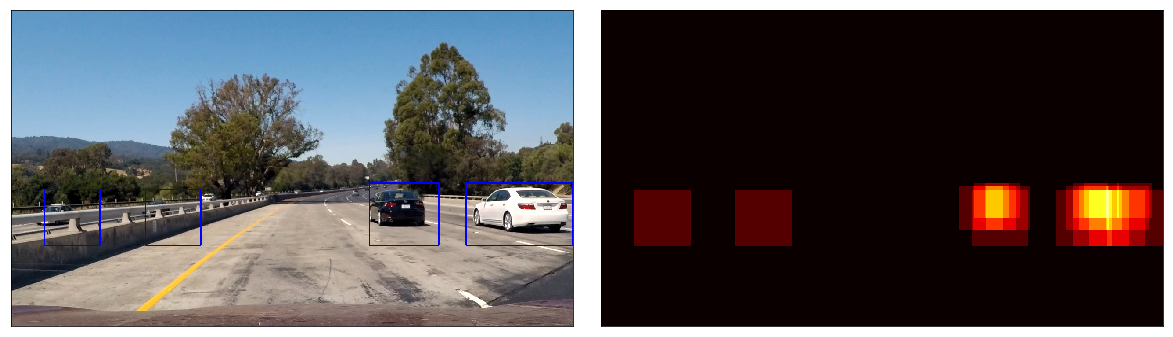

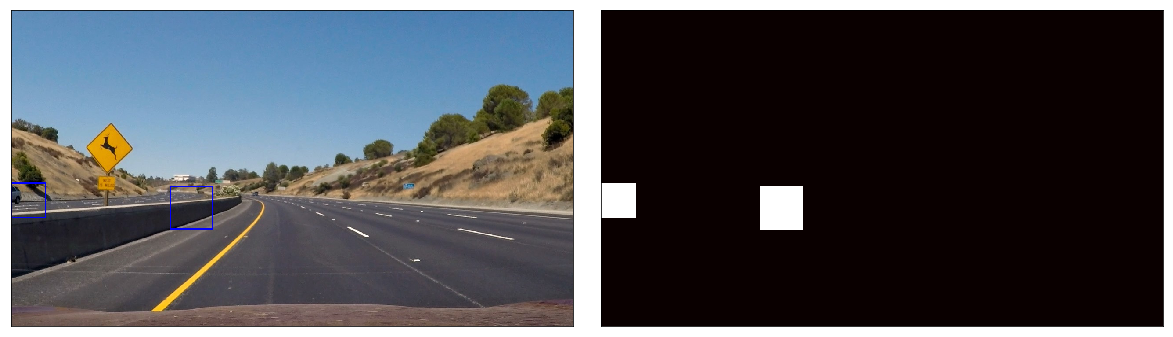

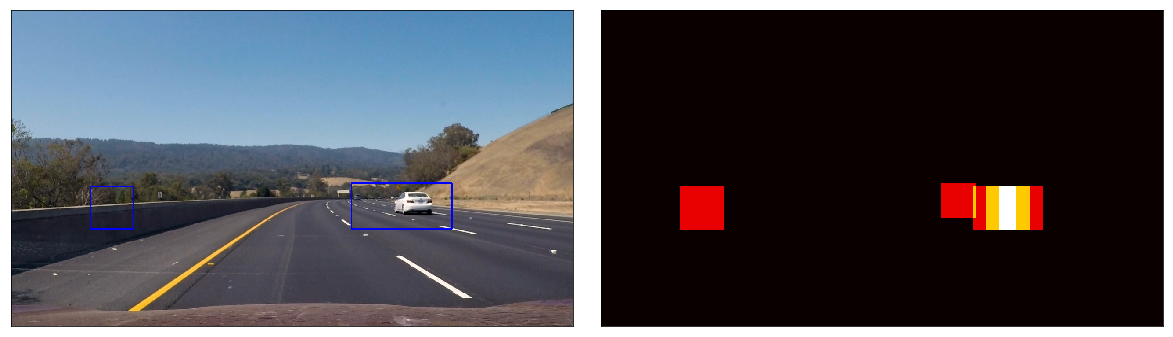

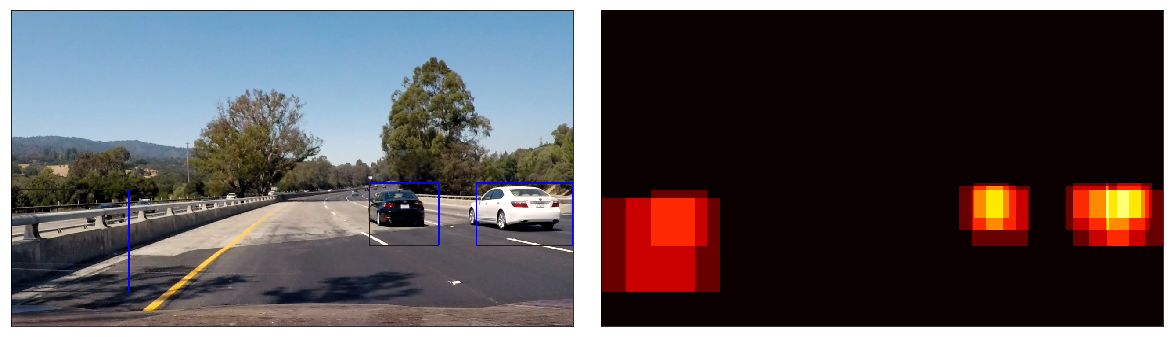

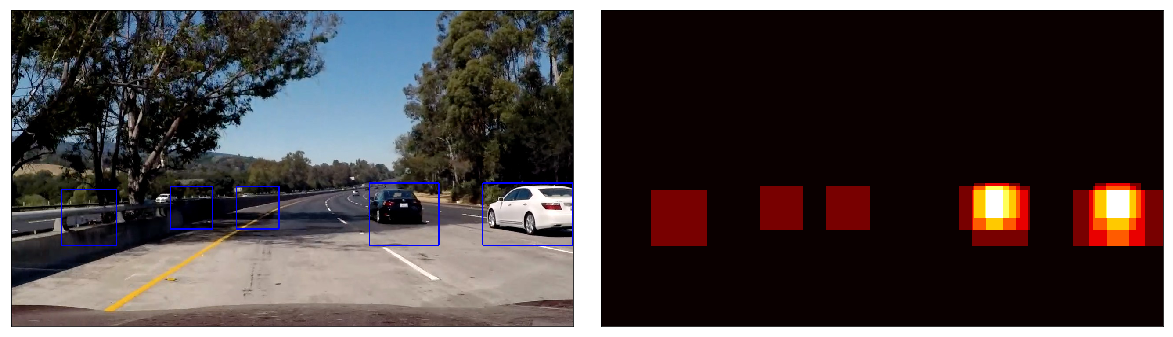

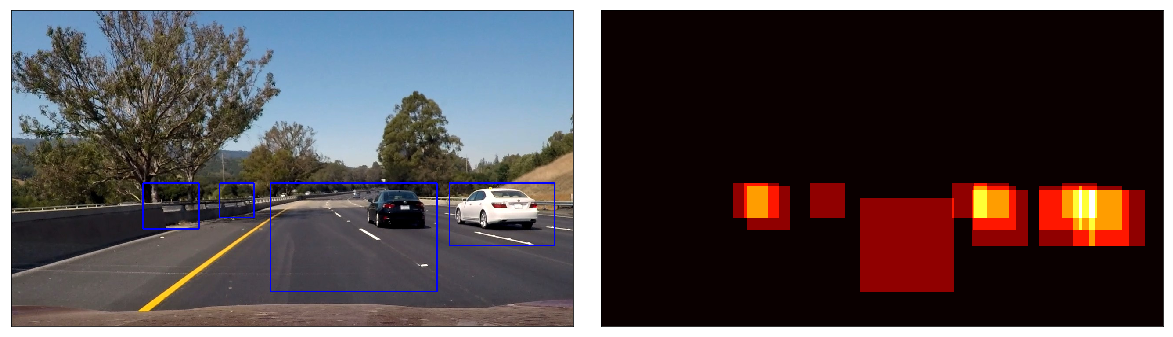

In [ ]:
for image_name in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_name)
    tracker = VehicleTracker(X_scaler, svc, image)
    tracker.process(image, draw_detections=True)

    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image)
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(tracker.heatmap, cmap='hot')
    plt.show()

In [ ]:
from moviepy.editor import VideoFileClip


video_output_name = 'project_video_annotated_vehicles.mp4'
video = VideoFileClip("project_video.mp4")
tracker = VehicleTracker(X_scaler, svc, video.get_frame(0))
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

[MoviePy] >>>> Building video project_video_annotated_vehicles.mp4
[MoviePy] Writing video project_video_annotated_vehicles.mp4


  0%|▋                                                                                                                                                                               | 5/1261 [00:12<53:55,  2.58s/it]